In [715]:
#Importing libraries and data.
import lightgbm as lgb
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

df__ = pd.read_csv('C:/Users/Admin/Desktop/dane/wig.csv', parse_dates=["Data"])

#Changing numerical index to Data
df__.set_index("Data", drop=False, inplace=True)
#Viewing types of columns, making sure that Date has a 'datetime' format.
df__.dtypes

Data          datetime64[ns]
Otwarcie             float64
Najwyzszy            float64
Najnizszy            float64
Zamkniecie           float64
Wolumen              float64
dtype: object

In [716]:
#Changing name of the columns and checking type of data
data = df__.rename(columns=dict(Data='Date', Otwarcie='Open', Najwyzszy='High', Najnizszy='Low', Zamkniecie='Close', Wolumen='Volume'))
data.dtypes
data.describe()

,Open,High,Low,Close,Volume
count,4768.000000,4768.000000,4768.000000,4768.000000,4.765000e+03
mean,41166.127294,41386.653712,40893.372244,41154.325180,5.472219e+07
std,15332.460379,15378.647042,15254.761738,15314.186033,4.777383e+07
min,11539.900000,11650.200000,11464.800000,11564.600000,1.727457e+06
25%,27553.600000,27678.200000,27278.900000,27440.100000,1.754025e+07
50%,44484.120000,44733.385000,44147.535000,44529.495000,4.342025e+07
75%,52909.107500,53118.110000,52663.325000,52886.290000,7.652914e+07
max,67607.050000,67933.050000,67144.100000,67568.500000,6.491139e+08


In [717]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [718]:
# Creating function, which counts an average price of a day and applying it to an existent dataset.

def VWAP(data):
    v = data.Volume.values
    h = data.High.values
    l = data.Low.values
    return data.assign(VWAP=(v*(h+l)/2)/v)
data = data.groupby(data.index.date, group_keys=False).apply(VWAP)

In [719]:
#Providing the model information about the time component in the DataFrame.
data.Date = pd.to_datetime(data.Date, format="%Y-%m-%d")
data["month"] = data.Date.dt.month
data["week"] = data.Date.dt.week
data["day"] = data.Date.dt.day
data["day_of_week"] = data.Date.dt.dayofweek
data.head()

,Date,Open,High,Low,Close,Volume,VWAP,month,week,day,day_of_week
Data,,,,,,,,,,,
2020-01-21,2001-01-02,17567.9,17710.2,17486.5,17672.8,4935736.0,17598.35,1,1,2,1
2020-01-21,2001-01-03,17520.7,17676.4,17319.7,17506.1,8818742.0,17498.05,1,1,3,2
2020-01-21,2001-01-04,17673.0,17959.2,17673.0,17875.9,8597278.0,17816.10,1,1,4,3
2020-01-21,2001-01-05,17862.3,17871.4,17508.5,17509.3,8211943.0,17689.95,1,1,5,4
2020-01-21,2001-01-08,17276.7,17276.7,17067.8,17119.3,7374110.0,17172.25,1,2,8,0


In [720]:
#Creating variables to use in lagging dataset
data.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume"]
window1 = 3
window2 = 7
window3 = 30
data

,Date,Open,High,Low,Close,Volume,VWAP,month,week,day,day_of_week
0,2001-01-02,17567.90,17710.20,17486.50,17672.80,4935736.0,17598.350,1,1,2,1
1,2001-01-03,17520.70,17676.40,17319.70,17506.10,8818742.0,17498.050,1,1,3,2
2,2001-01-04,17673.00,17959.20,17673.00,17875.90,8597278.0,17816.100,1,1,4,3
3,2001-01-05,17862.30,17871.40,17508.50,17509.30,8211943.0,17689.950,1,1,5,4
4,2001-01-08,17276.70,17276.70,17067.80,17119.30,7374110.0,17172.250,1,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...
4763,2020-01-15,59087.67,59162.08,58616.41,58671.25,38504406.0,58889.245,1,3,15,2
4764,2020-01-16,58824.50,58998.65,58718.97,58962.37,43852653.0,58858.810,1,3,16,3
4765,2020-01-17,58893.50,59130.30,58543.53,59039.84,34074400.0,58836.915,1,3,17,4
4766,2020-01-20,59082.18,59214.29,59014.56,59110.06,27949866.0,59114.425,1,4,20,0


In [721]:
#Wrapping lag_features into rolled data. Calculating mean and standard deviation and shifting it over one day.
data_rolled_3d = data[lag_features].rolling(window=window1, min_periods=0)
data_rolled_7d = data[lag_features].rolling(window=window2, min_periods=0)
data_rolled_30d = data[lag_features].rolling(window=window3, min_periods=0)

data_mean_3d = data_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
data_mean_7d = data_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
data_mean_30d = data_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

data_std_3d = data_rolled_3d.std().shift(1).reset_index().astype(np.float32)
data_std_7d = data_rolled_7d.std().shift(1).reset_index().astype(np.float32)
data_std_30d = data_rolled_30d.std().shift(1).reset_index().astype(np.float32)

In [722]:
#Creating a loop to define exogenous features:
for feature in lag_features:
    data[f"{feature}_mean_lag{window1}"] = data_mean_3d[feature]
    data[f"{feature}_mean_lag{window2}"] = data_mean_7d[feature]
    data[f"{feature}_mean_lag{window3}"] = data_mean_30d[feature]
    
    data[f"{feature}_std_lag{window1}"] = data_std_3d[feature]
    data[f"{feature}_std_lag{window2}"] = data_std_7d[feature]
    data[f"{feature}_std_lag{window3}"] = data_std_30d[feature]

data.fillna(data.mean(), inplace=True)

data.set_index("Date", drop=False, inplace=True)


In [723]:
#Splitting the data into train and test dataframe
data_train = data[data.Date < "2019"]
data_test = data[data.Date >= "2019"]

In [724]:
#
exogenous_features =["Volume_mean_lag3", "Volume_mean_lag7","Volume_mean_lag30", "Volume_std_lag3", "Volume_std_lag7", "Volume_std_lag30",
                     "High_mean_lag3", "High_mean_lag7", "High_mean_lag30", "High_std_lag3", "High_std_lag7", "High_std_lag30",
                     "Low_mean_lag3", "Low_mean_lag7", "Low_mean_lag30", "Low_std_lag3", "Low_std_lag7", "Low_std_lag30",
                     "month", "week", "day", "day_of_week"]

In [725]:
#Using python library pmdarima to find best fitting ARIMA model to the dataframe with the lowest AIC
model = auto_arima(data_train.VWAP, exogenous=data_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(data_train.VWAP, exogenous=data_train[exogenous_features])


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=70539.623, BIC=70719.198, Fit time=38.691 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=71420.761, BIC=71574.682, Fit time=7.801 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=70678.628, BIC=70838.963, Fit time=20.265 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=71170.776, BIC=71331.111, Fit time=25.260 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=70510.088, BIC=70683.250, Fit time=27.890 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=70660.817, BIC=70827.565, Fit time=28.921 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=70537.958, BIC=70717.533, Fit time=29.297 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=70534.423, BIC=70720.411, Fit time=30.072 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=70498.736, BIC=70665.484, Fit time=33.180 seconds
Fit ARIMA: 

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [726]:
#Checking the fit of the model on train dataframe
forecast = model.predict(n_periods=len(data_valid), exogenous=data_test[exogenous_features])
data_test["Forecast_ARIMAX"] = forecast

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


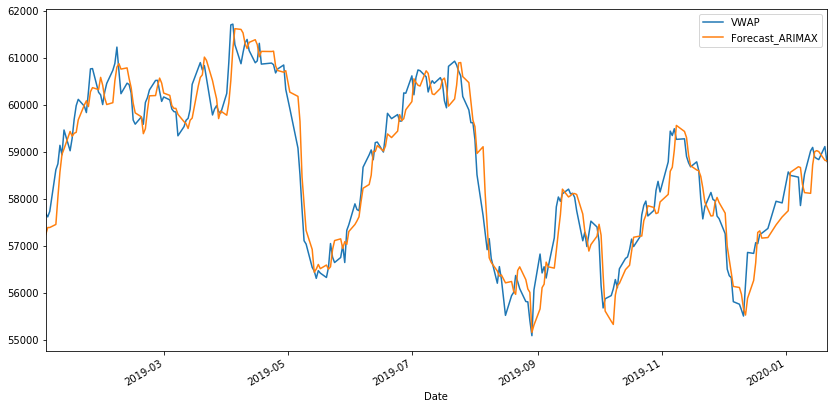

In [727]:
#Creating the plot VWAP vs Forecast:
data_test[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [728]:
#Root mean square error:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(data_test.VWAP, data_test.Forecast_ARIMAX)))

RMSE of Auto ARIMAX: 432.1856176356221


In [729]:
#Mean absolute error:
print("MAE of Auto ARIMAX:", mean_absolute_error(data_test.VWAP, data_test.Forecast_ARIMAX))

MAE of Auto ARIMAX: 347.3987644433007
